In [1]:
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip3 install transformers

     |████████████████████████████████| 2.5MB 37.4MB/s 
     |████████████████████████████████| 901kB 45.1MB/s 
     |████████████████████████████████| 3.3MB 47.5MB/s 


In [3]:
import torch 
from transformers import BertModel,BertConfig,AutoModel,AutoTokenizer,AdamW,get_linear_schedule_with_warmup,get_constant_schedule
import pandas as pd 
import numpy as np 
from torch.utils.data import Dataset,DataLoader
import seaborn as sns 
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import random
import os 
from matplotlib import pyplot as plt 
import pickle
from sklearn.metrics import accuracy_score

In [4]:
!cp /content/drive/MyDrive/Viettel3/Bert/val.csv /content
!cp /content/drive/MyDrive/Viettel3/test_n.csv /content

In [5]:
val=pd.read_csv('val.csv')
test=pd.read_csv('test_n.csv')

In [6]:
phobert=AutoModel.from_pretrained("vinai/phobert-base")
tokenizer=AutoTokenizer.from_pretrained("vinai/phobert-base")

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
labels={
0:"Van hoa",
1:"Chinh tri Xa hoi",
2:"Khoa hoc",
3:"Phap luat",
4:"Vi tinh",
5:"Suc khoe",
6:"Kinh doanh",
7:"The thao",
8:"The gioi",
9:"Doi song"
}

In [8]:
max_sequence_length=256

def encode_data(data):
  result=[]
  for text in data.text.values:
    temp=tokenizer.encode(text)
    if len(temp)<max_sequence_length:
      temp+=[1]*(max_sequence_length-len(temp))
    else:
      temp=temp[:max_sequence_length]
      temp[-1]=tokenizer.eos_token_id
    result.append(temp)
  return result

test['data']=encode_data(test)
val['data']=encode_data(val)

Token indices sequence length is longer than the specified maximum sequence length for this model (417 > 256). Running this sequence through the model will result in indexing errors


In [9]:
test_dataset_tensor=torch.utils.data.TensorDataset(torch.tensor(test['data'],dtype=torch.long),torch.tensor(test['label'],dtype=torch.long))
val_dataset_tensor=torch.utils.data.TensorDataset(torch.tensor(val['data'],dtype=torch.long),torch.tensor(val['label'],dtype=torch.long))

In [10]:
test_loader=DataLoader(test_dataset_tensor,batch_size=16,shuffle=True)
val_loader=DataLoader(val_dataset_tensor,batch_size=16,shuffle=True)

In [11]:
class Model_BERT(nn.Module):
  def __init__(self,n_classes,drop_prob=0.2):
    super(Model_BERT,self).__init__()
    self.n_classes=n_classes
    self.bert=phobert
    self.lstm=nn.LSTM(input_size=self.bert.config.hidden_size,
                      hidden_size=512,
                      batch_first=True,
                      num_layers=2,
                      bidirectional=True)
    self.linear=nn.Sequential(
        nn.Linear(512*4,512),
        nn.ReLU(),
        nn.Dropout(drop_prob),
        nn.Linear(512,self.n_classes)
    )
      
  def forward(self,x_batch):
    word_embedding = self.bert(x_batch)[0]
    lstm_out,_=self.lstm(word_embedding)
    avg_hidden=torch.mean(lstm_out,dim=1)
    max_hidden,_=torch.max(lstm_out,dim=1)
    input_linear=torch.cat((avg_hidden,max_hidden),dim=1)
    out=self.linear(input_linear)
    return out


In [12]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_state=torch.load('/content/drive/MyDrive/Viettel3/Bert/model16.pth')
model=Model_BERT(n_classes=10).to(device)
model.load_state_dict(model_state['model'])

<All keys matched successfully>

In [13]:
!nvidia-smi

Sun Jun 20 12:45:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W /  70W |   2430MiB / 15109MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
def test(model,data_loader):
  print("------------------------Evaluate---------------------------")
  model.eval()
  final_preds=[]
  final_true=[]
  for idx,(x_batch,y_batch) in enumerate(data_loader):
    x_batch=x_batch.to(device)
    y_batch=y_batch.to(device)
    outputs=model(x_batch)
    outputs=torch.softmax(outputs,dim=1)
    preds=torch.argmax(outputs,dim=1)
    final_preds.extend(preds.cpu().numpy().tolist())
    final_true.extend(y_batch.cpu().numpy().tolist())
    if idx%100==0:
      print(idx,end=' ')

  print()
  return final_true,final_preds

In [15]:
final_true_val,final_preds_val=test(model,val_loader)

------------------------Evaluate---------------------------
0 100 200 300 400 


In [17]:
final_true_test,final_preds_test=test(model,test_loader)

------------------------Evaluate---------------------------
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 


In [30]:
def plot(y_true,y_preds,target_names,file_name):
  cof=confusion_matrix(y_true,y_preds)
  df=pd.DataFrame(cof,index=target_names,columns=target_names)
  plt.figure(figsize=(12,9))
  heatmap=sns.heatmap(df,annot=True,fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),rotation=0,ha='right')
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),rotation=45,ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig(file_name+'.png')
  plt.show()

In [22]:
print(classification_report(final_true_val,final_preds_val,target_names=labels.values()))

                  precision    recall  f1-score   support

         Van hoa       0.92      0.91      0.91       616
Chinh tri Xa hoi       0.87      0.80      0.83      1043
        Khoa hoc       0.89      0.75      0.81       364
       Phap luat       0.92      0.92      0.92       773
         Vi tinh       0.92      0.97      0.94       496
        Suc khoe       0.86      0.96      0.91       676
      Kinh doanh       0.84      0.89      0.87       510
        The thao       0.99      0.98      0.98      1059
        The gioi       0.91      0.91      0.91       579
        Doi song       0.85      0.89      0.87       631

        accuracy                           0.90      6747
       macro avg       0.90      0.90      0.90      6747
    weighted avg       0.90      0.90      0.90      6747



In [24]:
print(classification_report(final_true_test,final_preds_test,target_names=labels.values()))

                  precision    recall  f1-score   support

         Van hoa       0.92      0.94      0.93      6250
Chinh tri Xa hoi       0.88      0.84      0.86      7567
        Khoa hoc       0.82      0.70      0.76      2096
       Phap luat       0.90      0.92      0.91      3788
         Vi tinh       0.91      0.97      0.94      4560
        Suc khoe       0.88      0.96      0.92      5417
      Kinh doanh       0.90      0.88      0.89      5276
        The thao       0.98      0.98      0.98      6667
        The gioi       0.94      0.93      0.94      6716
        Doi song       0.73      0.64      0.68      2036

        accuracy                           0.90     50373
       macro avg       0.89      0.88      0.88     50373
    weighted avg       0.90      0.90      0.90     50373



In [26]:
print(accuracy_score(final_true_val,final_preds_val))

0.90143767600415


In [27]:
print(accuracy_score(final_true_test,final_preds_test))

0.9047307089115201


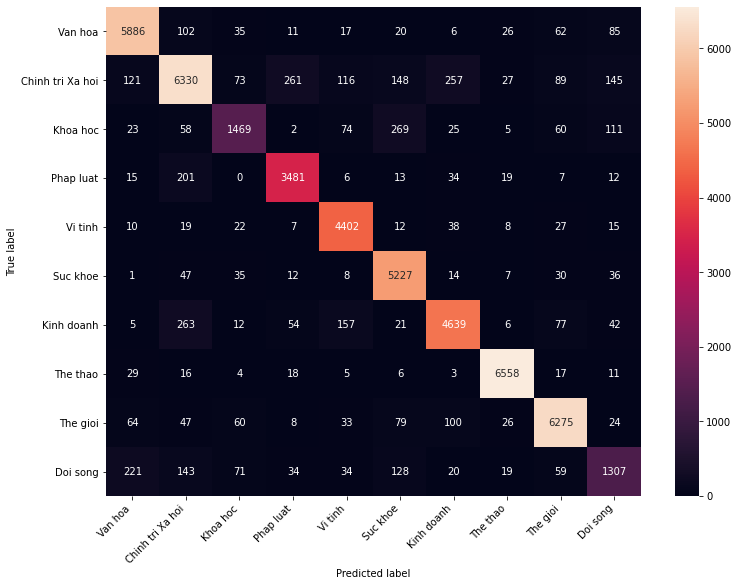

In [33]:
plot(final_true_test,final_preds_test,target_names=labels.values(),file_name='test_bert')

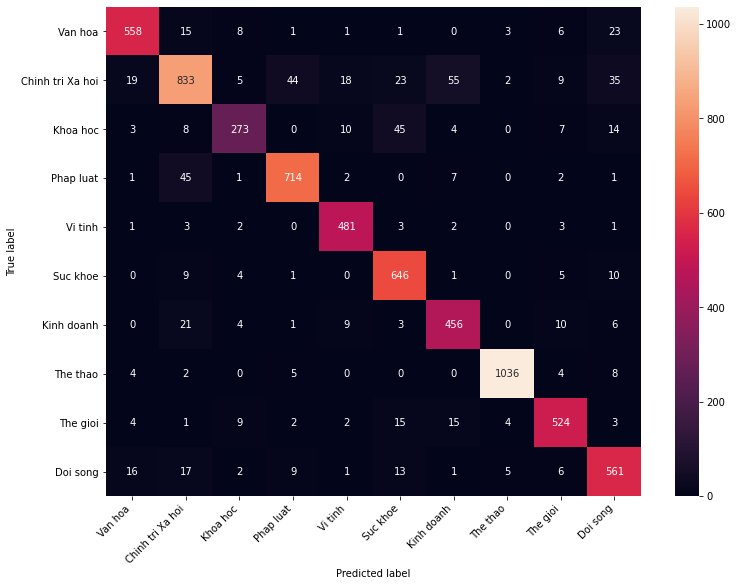

In [34]:
plot(final_true_val,final_preds_val,target_names=labels.values(),file_name='val_bert')